## 1. Setup

In [1]:
# If using Google Colab, mount Google Drive (optional, if dataset is in Drive)
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    print("✅ Google Drive mounted.")
except Exception as e:
    print("Google Colab not detected or drive already mounted:", e)

Mounted at /content/drive
✅ Google Drive mounted.


In [2]:
!pip install -q scikit-learn pandas numpy matplotlib seaborn transformers datasets torch sentencepiece wordcloud

In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"   # completely turn off wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_recall_fscore_support

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

from wordcloud import WordCloud

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

from datasets import Dataset

import re

## 2. Load Dataset

In [4]:
# ==== EDIT THIS PATH IF NEEDED ====
csv_path = "/content/news.csv"  # or e.g. "/content/drive/MyDrive/AI/news.csv"

import os
if not os.path.exists(csv_path):
    try:
        from google.colab import files  # type: ignore
        print("❗ news.csv not found. Please upload the Kaggle fake/real news CSV now.")
        uploaded = files.upload()
        csv_path = list(uploaded.keys())[0]
        print("Using uploaded file:", csv_path)
    except Exception as e:
        raise FileNotFoundError("news.csv not found and upload failed.") from e

df_raw = pd.read_csv(csv_path)
print("Shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())
df_raw.head()

❗ news.csv not found. Please upload the Kaggle fake/real news CSV now.


Saving news.csv to news.csv
Using uploaded file: news.csv
Shape: (500, 2)
Columns: ['text', 'label']


,text,label
0,a major tech company officially announced a pl...,1
1,Breaking: a financial regulator has been secre...,0
2,According to data published in a peer-reviewed...,1
3,Breaking: climate researchers has been secretl...,0
4,A controversial blog alleges that an internati...,0


### 2.1 Detect text and label columns automatically

In [5]:
text_col_candidates = [c for c in df_raw.columns if c.lower() in ["text", "content", "article", "body"]]
label_col_candidates = [c for c in df_raw.columns if c.lower() in ["label", "target", "class", "fake"]]

if not text_col_candidates:
    raise ValueError("Could not find a text column (expected one of: text, content, article, body). Please edit notebook.")
if not label_col_candidates:
    raise ValueError("Could not find a label column (expected one of: label, target, class, fake). Please edit notebook.")

TEXT_COL = text_col_candidates[0]
LABEL_COL = label_col_candidates[0]

print("Using text column:", TEXT_COL)
print("Using label column:", LABEL_COL)

df = df_raw[[TEXT_COL, LABEL_COL]].dropna().copy()

if df[LABEL_COL].dtype == 'object':
    df[LABEL_COL] = df[LABEL_COL].astype('category').cat.codes

print(df[LABEL_COL].value_counts())
df.head()

Using text column: text
Using label column: label
label
1    250
0    250
Name: count, dtype: int64


,text,label
0,a major tech company officially announced a pl...,1
1,Breaking: a financial regulator has been secre...,0
2,According to data published in a peer-reviewed...,1
3,Breaking: climate researchers has been secretl...,0
4,A controversial blog alleges that an internati...,0


## 3. Text Preprocessing

In [6]:
import re

def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+", " URL ", s)
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["clean_text"] = df[TEXT_COL].astype(str).apply(clean_text)
df[["clean_text", LABEL_COL]].head()

,clean_text,label
0,a major tech company officially announced a pl...,1
1,breaking a financial regulator has been secret...,0
2,according to data published in a peer reviewed...,1
3,breaking climate researchers has been secretly...,0
4,a controversial blog alleges that an internati...,0


### 3.1 Train–test split

In [7]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["clean_text"], df[LABEL_COL], test_size=0.2, random_state=42, stratify=df[LABEL_COL]
)

print("Train size:", len(X_train_text))
print("Test size:", len(X_test_text))

Train size: 400
Test size: 100


### 3.2 TF–IDF Vectorisation

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    stop_words="english"
)

X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

X_train_tfidf.shape, X_test_tfidf.shape

((400, 666), (100, 666))

## 4. Classical Machine Learning Models


========== Logistic Regression ==========
Accuracy: 1.0
Precision (weighted): 1.0
Recall (weighted): 1.0
F1 (weighted): 1.0

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



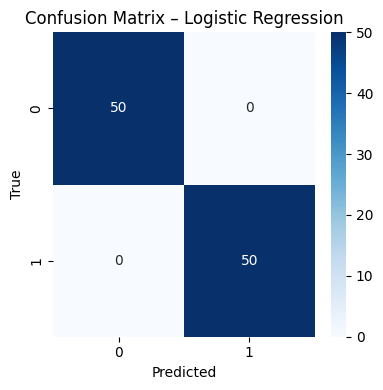

ROC–AUC: 1.0


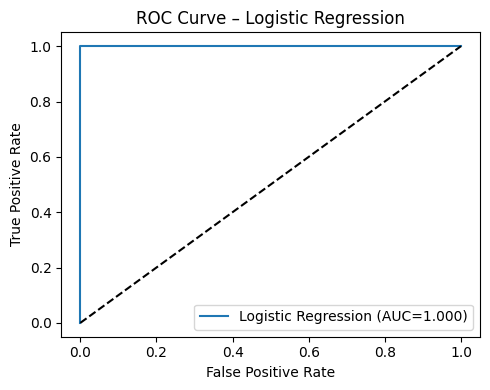


========== Multinomial Naïve Bayes ==========
Accuracy: 1.0
Precision (weighted): 1.0
Recall (weighted): 1.0
F1 (weighted): 1.0

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



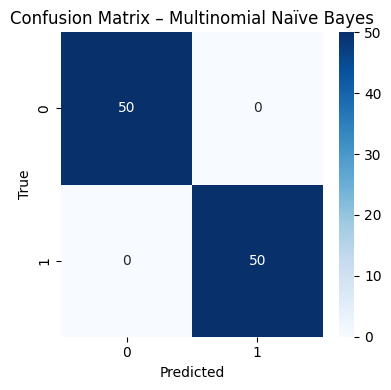

ROC–AUC: 1.0


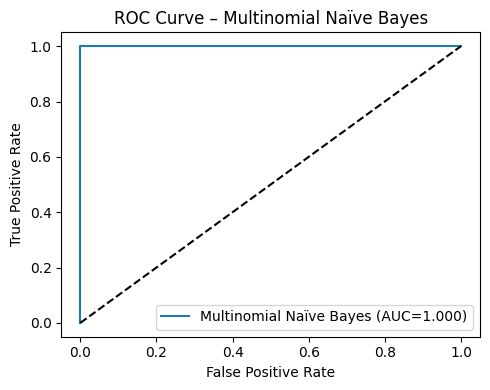


========== Linear SVM ==========
Accuracy: 1.0
Precision (weighted): 1.0
Recall (weighted): 1.0
F1 (weighted): 1.0

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



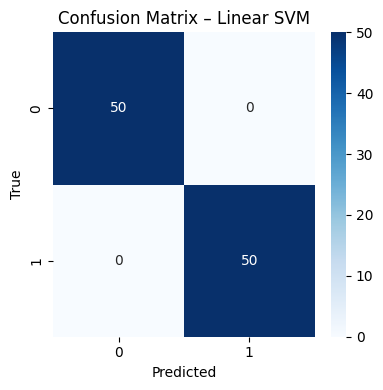

ROC–AUC: 1.0


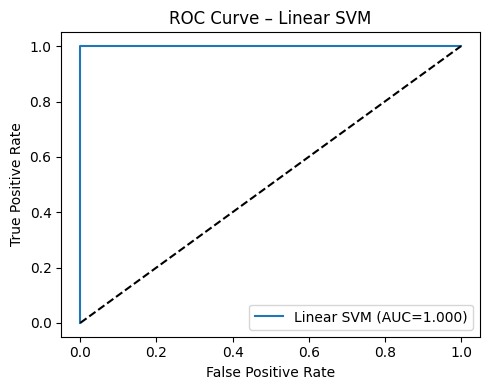

,model,accuracy,precision_weighted,recall_weighted,f1_weighted
0,Logistic Regression,1.0,1.0,1.0,1.0
1,Multinomial Naïve Bayes,1.0,1.0,1.0,1.0
2,Linear SVM,1.0,1.0,1.0,1.0


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def eval_binary_model(name, model, X_tr, y_tr, X_te, y_te, results_list):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="weighted")

    print(f"\n========== {name} ==========")
    print("Accuracy:", acc)
    print("Precision (weighted):", precision)
    print("Recall (weighted):", recall)
    print("F1 (weighted):", f1)
    print("\nClassification report:")
    print(classification_report(y_te, y_pred))

    cm = confusion_matrix(y_te, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    try:
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_te)[:,1]
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_te)
        else:
            y_scores = None

        if y_scores is not None:
            auc = roc_auc_score(y_te, y_scores)
            fpr, tpr, _ = roc_curve(y_te, y_scores)
            print("ROC–AUC:", auc)

            plt.figure(figsize=(5,4))
            plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
            plt.plot([0,1],[0,1],'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve – {name}")
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print("Could not compute ROC–AUC:", e)

    results_list.append({
        "model": name,
        "accuracy": acc,
        "precision_weighted": precision,
        "recall_weighted": recall,
        "f1_weighted": f1,
    })

results_ml = []

log_reg = LogisticRegression(max_iter=2000)
eval_binary_model("Logistic Regression", log_reg, X_train_tfidf, y_train, X_test_tfidf, y_test, results_ml)

nb = MultinomialNB()
eval_binary_model("Multinomial Naïve Bayes", nb, X_train_tfidf, y_train, X_test_tfidf, y_test, results_ml)

svm = LinearSVC()
eval_binary_model("Linear SVM", svm, X_train_tfidf, y_train, X_test_tfidf, y_test, results_ml)

pd.DataFrame(results_ml)

## 5. Word Importance (Logistic Regression + TF–IDF)

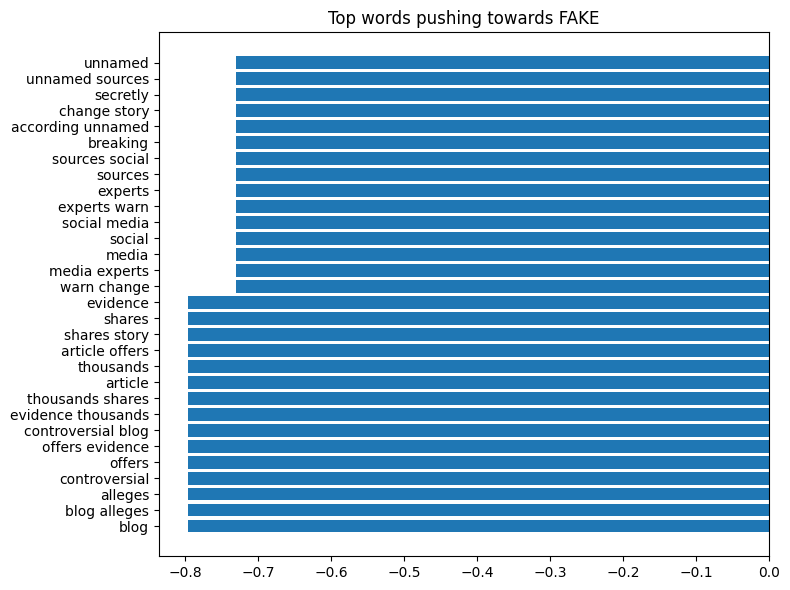

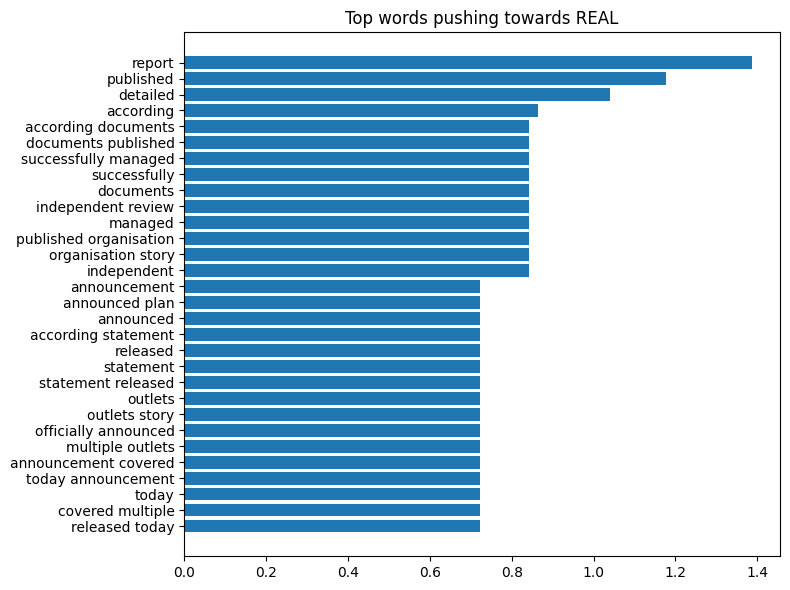

In [10]:
feature_names = np.array(vectorizer.get_feature_names_out())
coefs = log_reg.coef_[0]

top_fake_idx = np.argsort(coefs)[:30]
top_real_idx = np.argsort(coefs)[-30:]

plt.figure(figsize=(8,6))
plt.barh(feature_names[top_fake_idx], coefs[top_fake_idx])
plt.title("Top words pushing towards FAKE")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.barh(feature_names[top_real_idx], coefs[top_real_idx])
plt.title("Top words pushing towards REAL")
plt.tight_layout()
plt.show()

In [11]:
import os
os.environ["WANDB_DISABLED"] = "true"   # completely turn off wandb


## 6. DistilBERT Fine‑Tuning

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import numpy as np

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

MAX_SAMPLES = 10000
if len(df) > MAX_SAMPLES:
    df_dl = df.sample(MAX_SAMPLES, random_state=42).reset_index(drop=True)
else:
    df_dl = df.copy().reset_index(drop=True)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_dl["clean_text"].tolist(),
    df_dl[LABEL_COL].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_dl[LABEL_COL].tolist(),
)

train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_ds = Dataset.from_dict({"text": test_texts, "label": test_labels})

def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True, padding=False)

train_ds_tok = train_ds.map(tokenize_function, batched=True)
test_ds_tok = test_ds.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

id2label = {0: "FAKE", 1: "REAL"}
label2id = {"FAKE": 0, "REAL": 1}

bert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")

    return {
        "accuracy": acc,
        "precision_weighted": precision,
        "recall_weighted": recall,
        "f1_weighted": f1,
    }

batch_size = 8
num_epochs = 2

training_args = TrainingArguments(
    output_dir="./results-task4",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    report_to="none",
)

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_ds_tok,
    eval_dataset=test_ds_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3243942660.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted
1,0.150300,0.003125,1.000000,1.000000,1.000000,1.000000
2,0.002600,0.001900,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=100, training_loss=0.07645193099975586, metrics={'train_runtime': 328.1572, 'train_samples_per_second': 2.438, 'train_steps_per_second': 0.305, 'total_flos': 10466994296928.0, 'train_loss': 0.07645193099975586, 'epoch': 2.0})

In [13]:
bert_eval = trainer.evaluate()
bert_eval

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.0031251206528395414,
 'eval_accuracy': 1.0,
 'eval_precision_weighted': 1.0,
 'eval_recall_weighted': 1.0,
 'eval_f1_weighted': 1.0,
 'eval_runtime': 6.9278,
 'eval_samples_per_second': 14.435,
 'eval_steps_per_second': 1.877,
 'epoch': 2.0}

## 7. Simple Token Importance Example

In [14]:
example_text = test_texts[0]
print("Example text snippet:\n", example_text[:400], "...")

inputs = tokenizer(example_text, return_tensors="pt", truncation=True)
with torch.no_grad():
    outputs = bert_model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1).numpy()[0]

print("Predicted probs [FAKE, REAL]:", probs)

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
scores = outputs.logits.detach().numpy()[0]
importance = np.abs(scores).sum()

print("\nFirst 40 tokens (for illustration):")
for tok in tokens[:40]:
    print(tok, end=" ")

Example text snippet:
 an independent review found that a local charity successfully managed to invest in green infrastructure according to documents published by the organisation the story has generated discussion across multiple communities with commentators debating the potential consequences and accuracy of the information ...
Predicted probs [FAKE, REAL]: [0.00260442 0.99739563]

First 40 tokens (for illustration):
[CLS] an independent review found that a local charity successfully managed to invest in green infrastructure according to documents published by the organisation the story has generated discussion across multiple communities with commentators debating the potential consequences and accuracy of 

## 8. LDA Topic Modelling

In [15]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

lda_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english"
)
X_lda = lda_vectorizer.fit_transform(df["clean_text"])

n_topics = 8
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_topics = lda.fit_transform(X_lda)

vocab = np.array(lda_vectorizer.get_feature_names_out())
n_top_words = 10
for topic_idx, topic in enumerate(lda.components_):
    print(f"\nTopic #{topic_idx}")
    top_idx = topic.argsort()[-n_top_words:][::-1]
    print(", ".join(vocab[top_idx]))


Topic #0
review, independent, successfully, managed, documents, organisation, seen, night, outlet, suggest

Topic #1
today, statement, officially, outlets, released, announcement, announced, multiple, plan, covered

Topic #2
policy, public, introduce, new, leading, scientists, university, organisation, according, multiple

Topic #3
term, started, study, peer, reviewed, impact, data, analysts, long, say

Topic #4
thousands, shares, evidence, alleges, offers, blog, article, controversial, plan, launch

Topic #5
warn, unnamed, social, sources, secretly, experts, breaking, media, change, according

Topic #6
report, states, statistics, interviews, verified, includes, agency, international, detailed, access

Topic #7
apps, chain, circulating, checkers, confirm, immediately, fact, able, messaging, messages


### 8.1 Topic vs Label

In [16]:
topic_assignments = np.argmax(lda_topics, axis=1)
df_topics = pd.DataFrame({
    "topic": topic_assignments,
    "label": df[LABEL_COL].values
})

topic_label_counts = pd.crosstab(df_topics["topic"], df_topics["label"], normalize="index")
topic_label_counts.columns = ["FAKE", "REAL"]
topic_label_counts

,FAKE,REAL
topic,,
0,0.510000,0.490000
1,0.444444,0.555556
3,0.000000,1.000000
4,1.000000,0.000000
5,1.000000,0.000000
6,0.000000,1.000000
7,0.570000,0.430000


## 9. K‑Means Clustering

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_tfidf)

cluster_to_label = {}
for c in [0,1]:
    idx = np.where(cluster_labels == c)[0]
    if len(idx) == 0:
        continue
    majority = np.bincount(y_train.iloc[idx]).argmax()
    cluster_to_label[c] = majority

cluster_labels_test = kmeans.predict(X_test_tfidf)
y_pred_cluster = np.array([cluster_to_label[c] for c in cluster_labels_test])

acc_cluster = accuracy_score(y_test, y_pred_cluster)
precision_cluster, recall_cluster, f1_cluster, _ = precision_recall_fscore_support(
    y_test, y_pred_cluster, average="weighted"
)

print("=== K-Means (unsupervised) mapped to labels ===")
print("Accuracy:", acc_cluster)
print("Precision (weighted):", precision_cluster)
print("Recall (weighted):", recall_cluster)
print("F1 (weighted):", f1_cluster)

=== K-Means (unsupervised) mapped to labels ===
Accuracy: 0.45
Precision (weighted): 0.44832575444398515
Recall (weighted): 0.45
F1 (weighted): 0.4455086198205464


## 10. WordCloud Visualisation

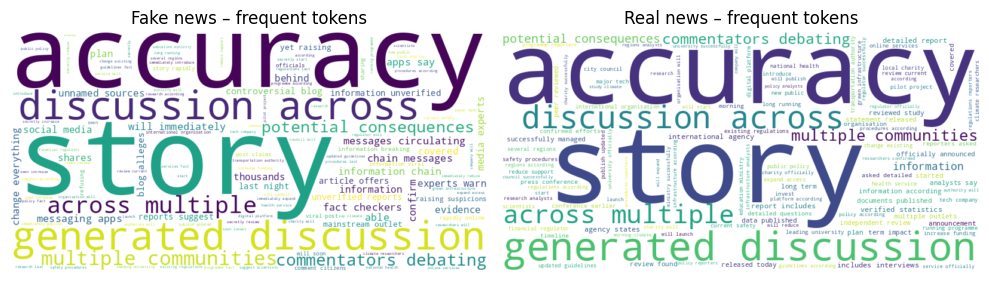

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fake_text = " ".join(df.loc[df[LABEL_COL]==0, "clean_text"].tolist())
real_text = " ".join(df.loc[df[LABEL_COL]==1, "clean_text"].tolist())

wc_fake = WordCloud(width=800, height=400, background_color="white").generate(fake_text)
wc_real = WordCloud(width=800, height=400, background_color="white").generate(real_text)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(wc_fake, interpolation="bilinear")
plt.axis("off")
plt.title("Fake news – frequent tokens")

plt.subplot(1,2,2)
plt.imshow(wc_real, interpolation="bilinear")
plt.axis("off")
plt.title("Real news – frequent tokens")

plt.tight_layout()
plt.show()

summary

